# LLM Comparison: Clean Data, EDA, Clustering, and Regression

This notebook loads the dataset, cleans it (duplicates, missing values, outliers), performs EDA, segments models via clustering (with optimal k via silhouette), and optionally trains an optimized RandomForest to predict Price Rating. All artifacts (plots, CSVs) are saved in the `outputs/` folder.

In [14]:
# Setup
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# Replace deprecated sns.set with set_theme
sns.set_theme(style='whitegrid')
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Paths
DATA_PATH = 'llm_comparison_dataset.csv'
OUTPUT_DIR = Path('outputs')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
CLEAN_CSV = 'llm_comparison_dataset_clean.csv'

print(f'Working directory: {os.getcwd()}')
print(f'Data path exists: {Path(DATA_PATH).exists()}')

Working directory: D:\KULIAH\SEMESTER 3\EXPLORATORY DATA ANALYSIS\UAS
Data path exists: True


## Helper functions

In [15]:
from typing import List, Tuple, Dict, Optional

def report_duplicates(df: pd.DataFrame) -> int:
    dupes = df.duplicated().sum()
    print(f'Duplicate rows detected: {dupes}')
    return dupes

def remove_duplicates(df: pd.DataFrame) -> pd.DataFrame:
    before = len(df)
    df2 = df.drop_duplicates().copy()
    print(f'Removed {before - len(df2)} duplicate rows. New shape: {df2.shape}')
    return df2

def summarize_missing(df: pd.DataFrame) -> pd.DataFrame:
    miss = df.isna().sum()
    pct = (miss / len(df) * 100).round(2)
    out = pd.DataFrame({'missing': miss, 'missing_%': pct})
    return out[out['missing'] > 0].sort_values('missing', ascending=False)

def convert_booleans_and_binary_cats(df: pd.DataFrame) -> Tuple[pd.DataFrame, Dict[str, Dict]]:
    df2 = df.copy()
    mappings: Dict[str, Dict] = {}
    # Explicit mapping for common boolean/binary columns
    explicit_map = {
        True: 1, False: 0,
        'True': 1, 'False': 0,
        'Yes': 1, 'No': 0,
        'Y': 1, 'N': 0,
        'Open-Source': 1, 'Closed-Source': 0,
        'Open Source': 1, 'Closed Source': 0,
        'open': 1, 'closed': 0
    }
    for col in df2.columns:
        ser = df2[col]
        # direct bool
        if ser.dtype == bool:
            df2[col] = ser.astype(int)
            mappings[col] = {True: 1, False: 0}
            continue
        if ser.dtype == 'object':
            uniques = pd.Series(ser.dropna().unique())
            if len(uniques) == 2:
                # Try explicit map first
                if all(u in explicit_map for u in uniques):
                    m = {u: explicit_map[u] for u in uniques}
                else:
                    # Alphabetical mapping fallback
                    sorted_vals = sorted(uniques.astype(str))
                    m = {sorted_vals[0]: 0, sorted_vals[1]: 1}
                df2[col] = ser.map(m).astype('Int64')
                mappings[col] = m
    return df2, mappings

def impute_missing(df: pd.DataFrame) -> Tuple[pd.DataFrame, Dict[str, float]]:
    df2 = df.copy()
    imputations: Dict[str, float] = {}
    for col in df2.columns:
        if df2[col].isna().any():
            if pd.api.types.is_numeric_dtype(df2[col]):
                val = df2[col].median()
                df2[col] = df2[col].fillna(val)
                imputations[col] = float(val)
            else:
                # mode may be empty if all NaN; guard it
                mode_vals = df2[col].mode(dropna=True)
                if len(mode_vals) > 0:
                    val = mode_vals.iloc[0]
                else:
                    val = 'Unknown'
                df2[col] = df2[col].fillna(val)
                imputations[col] = val if isinstance(val, (int, float)) else str(val)
    return df2, imputations

def iqr_cap_outliers(df: pd.DataFrame, factor: float = 1.5) -> Tuple[pd.DataFrame, pd.DataFrame]:
    df2 = df.copy()
    replaced_counts = {}
    bounds = {}
    for col in df2.select_dtypes(include=[np.number]).columns:
        ser = df2[col]
        q1 = ser.quantile(0.25)
        q3 = ser.quantile(0.75)
        iqr = q3 - q1
        if pd.isna(iqr) or iqr == 0:
            continue
        lower = q1 - factor * iqr
        upper = q3 + factor * iqr
        capped = ser.clip(lower, upper)
        replaced_counts[col] = int((ser != capped).sum())
        bounds[col] = (float(lower), float(upper))
        df2[col] = capped
    counts_df = pd.DataFrame({'replaced': pd.Series(replaced_counts)}).sort_values('replaced', ascending=False)
    return df2, counts_df

def select_clustering_features(df: pd.DataFrame, preferred: Optional[List[str]] = None, min_features: int = 2) -> List[str]:
    preferred = preferred or []
    available = [c for c in preferred if c in df.columns]
    if len(available) >= min_features:
        return available
    # Fallback: top-variance numeric features
    num = df.select_dtypes(include=[np.number])
    if num.shape[1] >= min_features:
        vars_ = num.var().sort_values(ascending=False)
        return list(vars_.head(max(min_features, min(4, len(vars_)))).index)
    return []

def best_k_by_silhouette(X: np.ndarray, k_min: int = 2, k_max: int = 8, random_state: int = 42) -> Tuple[Optional[int], pd.DataFrame]:
    n = X.shape[0]
    k_max_eff = min(k_max, max(2, n - 1))
    scores = []
    for k in range(k_min, k_max_eff + 1):
        try:
            km = KMeans(n_clusters=k, n_init=10, random_state=random_state)
            labels = km.fit_predict(X)
            # Silhouette needs at least 2 clusters and less than n unique labels
            if len(set(labels)) < 2 or len(set(labels)) >= n:
                continue
            score = silhouette_score(X, labels)
            scores.append({'k': k, 'silhouette': score})
        except Exception as e:
            continue
    df_scores = pd.DataFrame(scores)
    if not df_scores.empty:
        best_row = df_scores.loc[df_scores['silhouette'].idxmax()]
        return int(best_row['k']), df_scores
    return None, df_scores

def plot_correlation_heatmap(df: pd.DataFrame, title: str, save_path: Optional[Path] = None):
    num_cols = df.select_dtypes(include=[np.number]).columns
    if len(num_cols) < 2:
        print('Not enough numeric columns for correlation heatmap.')
        return
    plt.figure(figsize=(12, 9))
    corr = df[num_cols].corr()
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
    plt.title(title)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=150)
    plt.show()

def pca_scatter(X: np.ndarray, labels: np.ndarray, title: str, save_path: Optional[Path] = None):
    if X.shape[1] < 2:
        print('Not enough dimensions for PCA scatter.')
        return
    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    X2 = pca.fit_transform(X)
    plt.figure(figsize=(10, 7))
    sns.scatterplot(x=X2[:,0], y=X2[:,1], hue=labels, palette='viridis', s=90, alpha=0.85)
    plt.title(title)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=150)
    plt.show()

def regression_features(df: pd.DataFrame, target: str, extra_exclude: Optional[List[str]] = None) -> List[str]:
    exclude = set(extra_exclude or []) | {target}
    # numeric only and non-constant
    num = df.select_dtypes(include=[np.number])
    variances = num.var()
    keep = [c for c in num.columns if c not in exclude and variances.get(c, 0) > 0]
    return keep

def evaluate_regression(y_true, y_pred) -> Dict[str, float]:
    from sklearn.metrics import mean_squared_error, r2_score
    mse = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    r2 = r2_score(y_true, y_pred)
    return {'MSE': float(mse), 'RMSE': rmse, 'R2': float(r2)}


## 1) Load data

In [16]:
assert Path(DATA_PATH).exists(), f'Data file not found: {DATA_PATH}'
df = pd.read_csv(DATA_PATH)
# Clean column names whitespace
df.columns = df.columns.str.strip()
print(df.shape)
display(df.head(3))
display(df.dtypes.to_frame('dtype').T)

(200, 15)


,Model,Provider,Context Window,Speed (tokens/sec),Latency (sec),Benchmark (MMLU),Benchmark (Chatbot Arena),Open-Source,Price / Million Tokens,Training Dataset Size,Compute Power,Energy Efficiency,Quality Rating,Speed Rating,Price Rating
0,DeepSeek-4,Deepseek,128000,95,2.74,85,1143,1,18.81,760952565,13,0.50,2,2,3
1,Llama-8,Meta AI,300000,284,3.21,71,1390,1,3.98,22891342,22,2.07,1,3,3
2,Llama-5,Meta AI,300000,225,2.95,85,1406,0,1.02,827422145,21,0.95,2,3,2


,Model,Provider,Context Window,Speed (tokens/sec),Latency (sec),Benchmark (MMLU),Benchmark (Chatbot Arena),Open-Source,Price / Million Tokens,Training Dataset Size,Compute Power,Energy Efficiency,Quality Rating,Speed Rating,Price Rating
dtype,object,object,int64,int64,float64,int64,int64,int64,float64,int64,int64,float64,int64,int64,int64


## 2) Duplicates

In [17]:
dupes = report_duplicates(df)
if dupes > 0:
    df = remove_duplicates(df)
else:
    print('No duplicate rows found.')

Duplicate rows detected: 0
No duplicate rows found.


## 3) Missing values and type fixes

In [18]:
print('Missing values before:')
display(summarize_missing(df))

df, bin_maps = convert_booleans_and_binary_cats(df)
if bin_maps:
    print('Binary mappings applied:')
    display(pd.DataFrame({k: pd.Series(v) for k, v in bin_maps.items()}))

df, imputes = impute_missing(df)
print('Imputations used:')
display(pd.DataFrame.from_dict(imputes, orient='index', columns=['imputed_value']))

print('Missing values after:')
display(summarize_missing(df))

Missing values before:


,missing,missing_%


Imputations used:


,imputed_value


Missing values after:


,missing,missing_%


## 4) Outlier capping (IQR winsorization)

In [19]:
df, outlier_counts = iqr_cap_outliers(df, factor=1.5)
print('Outlier capping summary (number of values capped):')
display(outlier_counts)
outlier_counts.to_csv(OUTPUT_DIR / 'outlier_capping_summary.csv')

Outlier capping summary (number of values capped):


,replaced
Context Window,0
Speed (tokens/sec),0
Latency (sec),0
Benchmark (MMLU),0
Benchmark (Chatbot Arena),0
Open-Source,0
Price / Million Tokens,0
Training Dataset Size,0
Compute Power,0
Energy Efficiency,0


## 5) Save cleaned dataset

In [20]:
df.to_csv(CLEAN_CSV, index=False)
print(f'Cleaned dataset saved to: {CLEAN_CSV}')

Cleaned dataset saved to: llm_comparison_dataset_clean.csv


## 6) EDA: Descriptive statistics and correlation

,Model,Provider,Context Window,Speed (tokens/sec),Latency (sec),Benchmark (MMLU),Benchmark (Chatbot Arena),Open-Source,Price / Million Tokens,Training Dataset Size,Compute Power,Energy Efficiency,Quality Rating,Speed Rating,Price Rating
count,200,200,200.0,200.00,200.00000,200.000,200.00,200.00,200.0000,200.0,200.000,200.0000,200.0,200.000,200.00
unique,70,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Command-9,Cohere,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,8,34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,637180.0,163.24,9.35875,77.945,1192.96,0.49,14.4752,490264251.8,46.915,2.5191,1.9,2.275,2.91


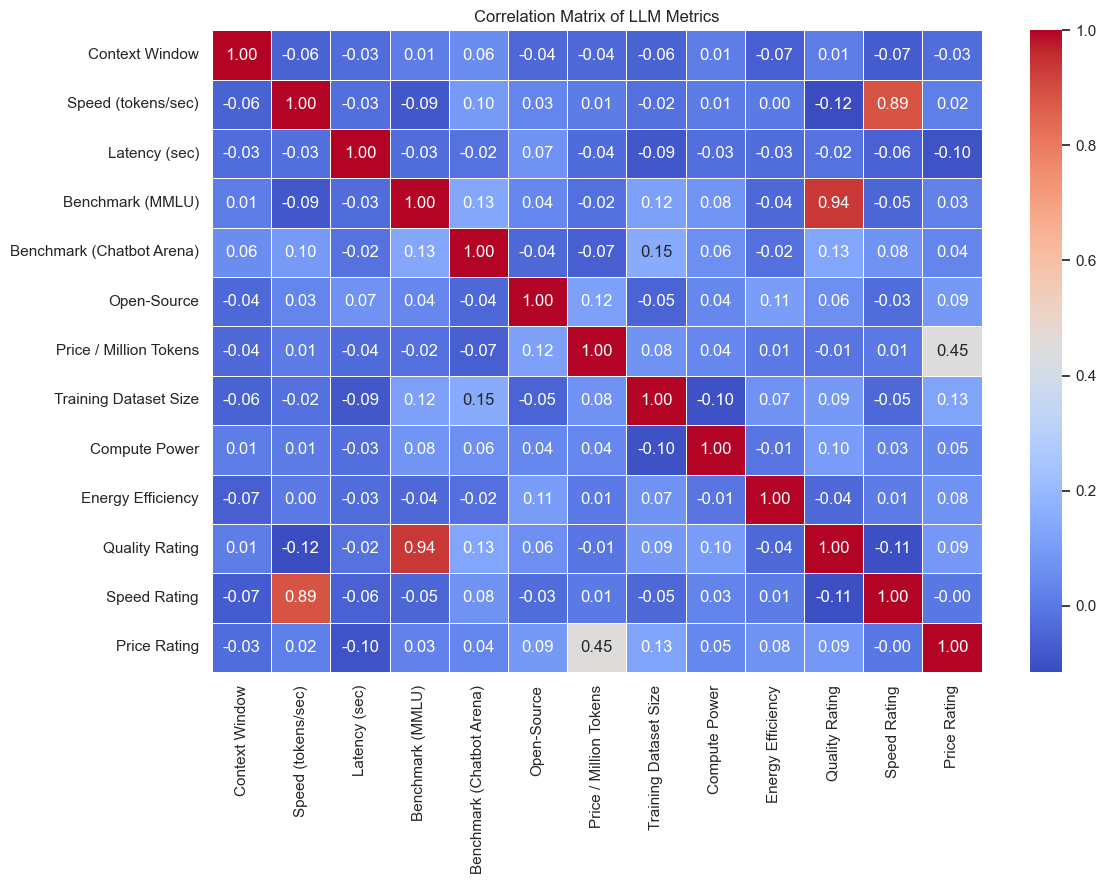

In [21]:
desc = df.describe(include='all')
desc.to_csv(OUTPUT_DIR / 'descriptive_statistics.csv')
display(desc.head())
plot_correlation_heatmap(df, title='Correlation Matrix of LLM Metrics', save_path=OUTPUT_DIR / 'correlation_heatmap.png')

## 6.5) Relationship: Price Rating (x) vs Price / Million Tokens (y)

Price/M Tokens vs Price Rating metrics: {'MSE': 62.83711517083787, 'RMSE': 7.9269865125934125, 'R2': 0.2010082304406502, 'Coefficient': 13.11553862894452, 'Intercept': -23.691017410228554}


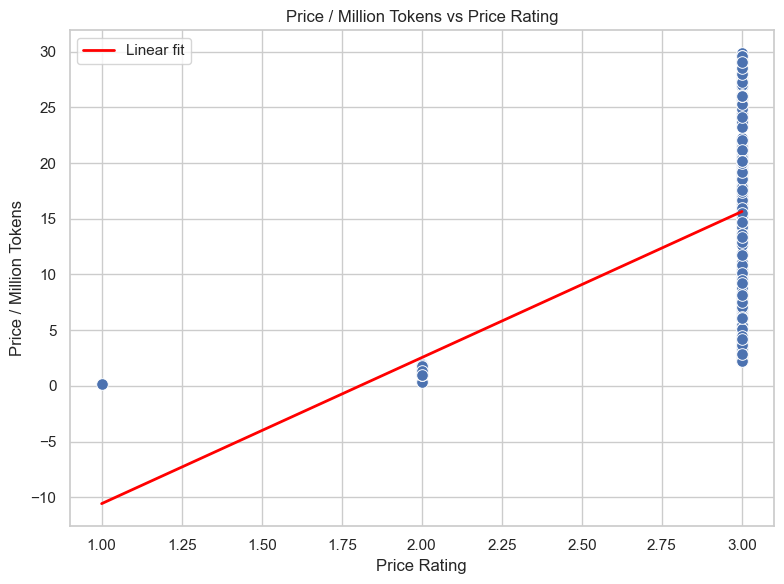

In [22]:
# Scatter + simple linear regression between Price Rating and Price / Million Tokens
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

x_col = 'Price Rating'
y_col = 'Price / Million Tokens'

if x_col not in df.columns or y_col not in df.columns:
    print(f"Required columns not found: {x_col}, {y_col}. Skipping this analysis.")
else:
    dxy = df[[x_col, y_col]].dropna().copy()
    # Guard for constant x or insufficient rows
    if (len(dxy) < 3) or (dxy[x_col].nunique() < 2):
        print('Not enough variation or rows to fit regression.')
    else:
        X = dxy[[x_col]].values
        y = dxy[y_col].values
        lr = LinearRegression()
        lr.fit(X, y)
        y_hat = lr.predict(X)
        mse = mean_squared_error(y, y_hat)
        rmse = float(np.sqrt(mse))
        r2 = r2_score(y, y_hat)
        summary = {
            'MSE': float(mse),
            'RMSE': rmse,
            'R2': float(r2),
            'Coefficient': float(lr.coef_[0]),
            'Intercept': float(lr.intercept_)
        }
        print('Price/M Tokens vs Price Rating metrics:', summary)
        pd.DataFrame([summary]).to_csv(OUTPUT_DIR / 'price_per_million_tokens_vs_price_rating_metrics.csv', index=False)

        # Plot
        plt.figure(figsize=(8,6))
        sns.scatterplot(x=dxy[x_col], y=dxy[y_col], s=70)
        xs = np.linspace(dxy[x_col].min(), dxy[x_col].max(), 100).reshape(-1, 1)
        plt.plot(xs, lr.predict(xs), color='red', linewidth=2, label='Linear fit')
        plt.title('Price / Million Tokens vs Price Rating')
        plt.xlabel('Price Rating')
        plt.ylabel('Price / Million Tokens')
        plt.legend()
        plt.tight_layout()
        plt.savefig(OUTPUT_DIR / 'price_per_million_tokens_vs_price_rating.png', dpi=150)
        plt.show()

## 7) Clustering: Optimal k via silhouette, PCA visualization

Selected clustering features: ['Benchmark (MMLU)', 'Benchmark (Chatbot Arena)', 'Price / Million Tokens', 'Speed (tokens/sec)']


,k,silhouette
0,2,0.195066
1,3,0.205180
2,4,0.223848
3,5,0.232351
4,6,0.224428
5,7,0.232614
6,8,0.222103


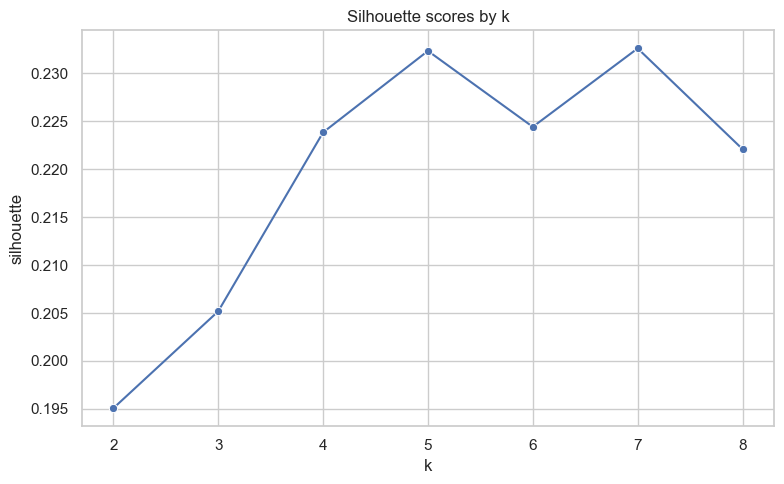

Best k selected: 7
Cluster counts:


Cluster
4    35
0    33
5    31
6    30
3    27
1    25
2    19
Name: count, dtype: int64

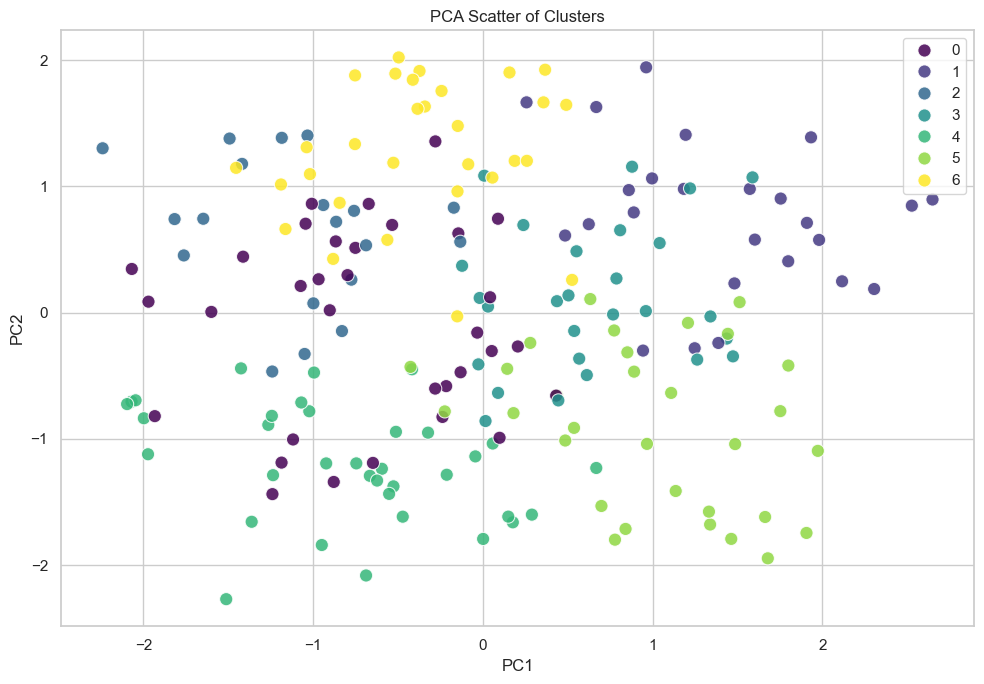

In [23]:
preferred_features = ['Benchmark (MMLU)', 'Benchmark (Chatbot Arena)', 'Price / Million Tokens', 'Speed (tokens/sec)']
cluster_feats = select_clustering_features(df, preferred_features, min_features=2)
print('Selected clustering features:', cluster_feats)
can_cluster = len(cluster_feats) >= 2 and len(df) >= 4
if not can_cluster:
    print('Not enough data/features to perform clustering. Skipping.')
else:
    scaler = StandardScaler()
    Xc = scaler.fit_transform(df[cluster_feats])
    k_best, sil_scores = best_k_by_silhouette(Xc, k_min=2, k_max=8, random_state=RANDOM_STATE)
    display(sil_scores)
    if not sil_scores.empty:
        plt.figure(figsize=(8,5))
        sns.lineplot(x='k', y='silhouette', data=sil_scores, marker='o')
        plt.title('Silhouette scores by k')
        plt.tight_layout()
        plt.savefig(OUTPUT_DIR / 'silhouette_scores.png', dpi=150)
        plt.show()
    if k_best is None:
        print('Could not determine best k via silhouette; defaulting to k=3')
        k_best = 3
    print(f'Best k selected: {k_best}')
    kmeans = KMeans(n_clusters=int(k_best), n_init=10, random_state=RANDOM_STATE)
    df['Cluster'] = kmeans.fit_predict(Xc)
    print('Cluster counts:')
    display(df['Cluster'].value_counts())
    # PCA scatter
    pca_scatter(Xc, df['Cluster'].values, title='PCA Scatter of Clusters', save_path=OUTPUT_DIR / 'cluster_pca_scatter.png')
    # Save clustered data preview
    df.to_csv(OUTPUT_DIR / 'data_with_clusters.csv', index=False)

## 8) Regression: Predict Price Rating with optimized RandomForest

Best params: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 30}
Evaluation: {'MSE': 0.0004905891705469284, 'RMSE': 0.02214924762936494, 'R2': 0.9929284443885127}


,Feature,Importance
6,Price / Million Tokens,0.993589
8,Compute Power,0.004209
2,Latency (sec),0.000829
0,Context Window,0.000407
7,Training Dataset Size,0.000254
9,Energy Efficiency,0.000248
4,Benchmark (Chatbot Arena),0.000173
1,Speed (tokens/sec),0.000110
3,Benchmark (MMLU),0.000091
5,Open-Source,0.000091


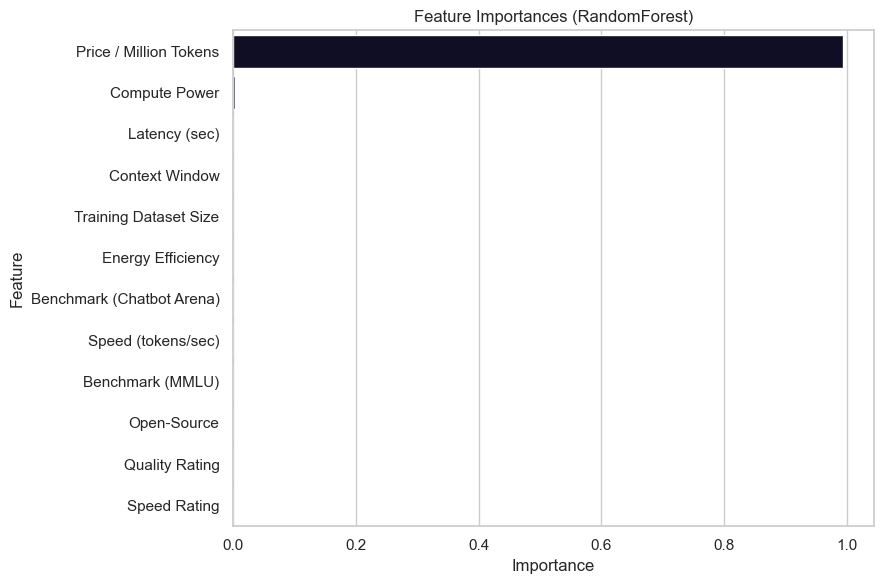

In [24]:
target_col = 'Price Rating'
if target_col not in df.columns:
    print(f'Target column \'{target_col}\' not found. Skipping regression.')
else:
    feature_cols = regression_features(df, target=target_col, extra_exclude=['Cluster'])
    if len(feature_cols) < 2:
        print('Not enough predictive features after filtering. Skipping regression.')
    else:
        X = df[feature_cols]
        y = df[target_col]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
        rf = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)
        param_dist = {
            'n_estimators': [100, 200, 300, 500],
            'max_depth': [None, 5, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['auto', 'sqrt', 0.5, None]
        }
        search = RandomizedSearchCV(
            rf, param_distributions=param_dist, n_iter=25, cv=3, scoring='r2',
            random_state=RANDOM_STATE, n_jobs=-1, verbose=0
        )
        search.fit(X_train, y_train)
        best_rf = search.best_estimator_
        print('Best params:', search.best_params_)
        y_pred = best_rf.predict(X_test)
        metrics = evaluate_regression(y_test, y_pred)
        print('Evaluation:', metrics)
        pd.DataFrame([metrics]).to_csv(OUTPUT_DIR / 'regression_metrics.csv', index=False)
        # Feature importances
        fi = pd.DataFrame({
            'Feature': feature_cols,
            'Importance': best_rf.feature_importances_
        }).sort_values('Importance', ascending=False)
        display(fi)
        fi.to_csv(OUTPUT_DIR / 'feature_importances.csv', index=False)
        plt.figure(figsize=(9,6))
        sns.barplot(data=fi, x='Importance', y='Feature', palette='magma')
        plt.title('Feature Importances (RandomForest)')
        plt.tight_layout()
        plt.savefig(OUTPUT_DIR / 'feature_importances.png', dpi=150)
        plt.show()


In [25]:
# This cell performs a simple test of the regression pipeline:
# - Confirms feature selection returns >=2 features
# - Trains RandomForest on a small train/test split
# - Ensures predictions are the correct shape
# - Verifies metrics dict has expected keys and finite values
import math

_target = 'Price Rating'
if _target not in df.columns:
    print(f"Test skipped: target '{_target}' not found.")
else:
    _features = regression_features(df, target=_target, extra_exclude=['Cluster'])
    if len(_features) < 2:
        print('Test skipped: not enough predictive features after filtering.')
    else:
        X = df[_features]
        y = df[_target]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
        rf = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        assert y_pred.shape[0] == y_test.shape[0], 'Prediction length mismatch'
        _metrics = evaluate_regression(y_test, y_pred)
        for k in ['MSE', 'RMSE', 'R2']:
            assert k in _metrics, f"Missing metric: {k}"
            assert isinstance(_metrics[k], (int, float)), f"Metric {k} is not numeric"
            assert math.isfinite(_metrics[k]), f"Metric {k} is not finite"
        print('Regression test PASSED:', _metrics)


Regression test PASSED: {'MSE': 6.000000000000012e-05, 'RMSE': 0.007745966692414842, 'R2': 0.9991351351351352}


## 9) Save final analyzed dataset

In [26]:
final_path = OUTPUT_DIR / 'fully_analyzed_llm_data.csv'
df.to_csv(final_path, index=False)
print(f'Final dataset saved to: {final_path}')

Final dataset saved to: outputs\fully_analyzed_llm_data.csv
